<a href="https://colab.research.google.com/github/Nirzaree/Detecting-Roads-from-Satellite-Images/blob/master/Masachusetts_Roads_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will look at satellite imagery data from Masachusetts and detect roads from the images. 

- The dataset has been obtained from  [kaggle](https://www.kaggle.com/insaff/massachusetts-roads-dataset)

- The data is organized as follows: 

```
.
└── training
    ├── input
    └── output
├── testing
│   ├── input
│   └── output

```
where input folder contains the images and output folder contains the corresponding mask images. 

- The size of the images is: <br/>
(length, width, color_channels) = (1500, 1500, 3) 

- The two tasks in the analysis are:
  - Data Pipeline:  Preprocessing the raw images to make them ready for the deep learning model
  - Deep Learning model: Build a deep learning model to identify roads from the images

- Data pipeline has accomplished the following steps: 
  - Crop input images from (1500, 1500, 3) into multiple smaller images of size (256, 256, 3) 
  - Apply similar operation on the mask images 
  - Save images as h5 files. 

- This notebook will focus on the Deep Learning model building with data inputs being the h5 images and masks from the data pipeline done in a different notebook.   



### Setup

In [ ]:
!pip install git+https://github.com/qubvel/segmentation_models

  Cloning https://github.com/qubvel/segmentation_models to /tmp/pip-req-build-3jiftpih
  Running command git clone -q https://github.com/qubvel/segmentation_models /tmp/pip-req-build-3jiftpih
  Running command git submodule update --init --recursive -q
     |████████████████████████████████| 50 kB 3.1 MB/s 
  Created wheel for segmentation-models: filename=segmentation_models-1.0.1-py3-none-any.whl size=33810 sha256=2b4654e9ffb3ebb710ae07815e11fcd59ab71d75a3f234a643ce29f49919b43f
  Stored in directory: /tmp/pip-ephem-wheel-cache-wi5rd74u/wheels/02/cd/18/61c0bbb8766acfec68f9d20618886b7b38dfeeb95865b6ba00
Successfully built segmentation-models


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt 

import h5py

from sklearn.model_selection import train_test_split

In [ ]:
seed = 42

### Load Data

For the model training we are loading a subset (2000 images) of the complete dataset (which is ~21000 images), since larger training size requires more RAM than is available in the Colab Basic version, leading to training session crashing. 

In [ ]:
images_file = '/content/drive/MyDrive/Data/MasachusettsRoads/road_images_2000.h5py'
masks_file = '/content/drive/MyDrive/Data/MasachusettsRoads/road_masks_2000.h5py'

In [ ]:
hfile = h5py.File(images_file,'r')
n1 = hfile.get('images')
images = np.array(n1)
print(images.shape)
hfile.close()

(2000, 256, 256, 3)


In [ ]:
hfile = h5py.File(masks_file,'r')
n1 = hfile.get('masks')
masks = np.array(n1)
print(masks.shape)
hfile.close()

(2000, 256, 256)


### Explore Data

### Plot few masks and images

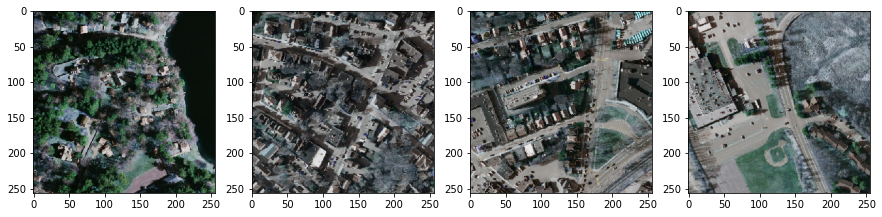

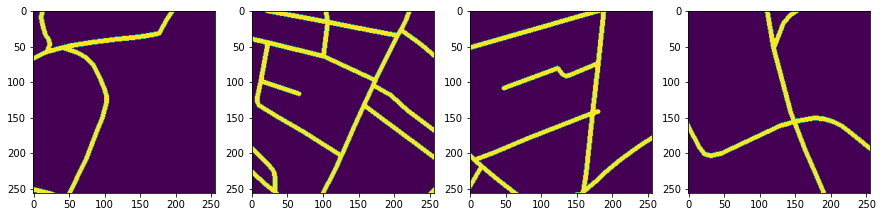

In [ ]:
plt.figure(figsize = (15,10))
for ind in range(4):
  plt.subplot(1,4,ind+1)
  plt.imshow(images[ind])
  
plt.figure(figsize = (15,10))
for ind in range(4):
  plt.subplot(1,4,ind+1)
  plt.imshow(masks[ind])


## Split data

In [ ]:
masks = np.expand_dims(masks, -1)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    images,
    masks,
    test_size = 0.2,
    random_state = seed
)

In [ ]:
del images,masks

In [ ]:
print("Training Dataset: ")
print("number of samples = ",X_train.shape[0])
print("shape of images = ",X_train.shape)
print("shape of masks = ",y_train.shape)
print("Test Dataset: ")
print("number of samples = ",X_test.shape[0])
print("shape of images = ",X_test.shape)
print("shape of masks = ",y_test.shape)

Training Dataset: 
number of samples =  1600
shape of images =  (1600, 256, 256, 3)
shape of masks =  (1600, 256, 256, 1)
Test Dataset: 
number of samples =  400
shape of images =  (400, 256, 256, 3)
shape of masks =  (400, 256, 256, 1)


## Define Model

In [ ]:
from segmentation_models import Unet
import segmentation_models as sm

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.


'tf.keras'

In [ ]:
model = Unet(
    backbone_name = 'efficientnetb0',
    encoder_weights = 'imagenet',
    encoder_freeze = False
)

16818176/16804768 [==============================] - 0s 0us/step


### Define custom loss metric and accuracy metric

In [ ]:
#Source: https://towardsdatascience.com/metrics-to-evaluate-your-semantic-segmentation-model-6bcb99639aa2
from keras import backend as K
def iou_coef(y_true, y_pred, smooth=1):
  intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
  union = K.sum(y_true,[1,2,3])+K.sum(y_pred,[1,2,3])-intersection
  iou = K.mean((intersection + smooth) / (union + smooth), axis=0)
  
  return iou

In [ ]:
def dice_coef(y_true, y_pred, smooth = 1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def soft_dice_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

#### Hyperparameters

In [ ]:
EPOCHS = 100
LEARNING_RATE = 0.0001
BATCH_SIZE = 16

#### Define callbacks

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

In [ ]:
model_path = './Models/model_2000img_256px.h5'

modelcheckpoint = ModelCheckpoint(
    filepath = model_path,
    monitor = "val_loss",
    mode = "min",
    save_best_only = True,
    verbose = 1
)

earlystopping = EarlyStopping(
    monitor = "val_loss",
    min_delta = 0,
    patience = 5,
    verbose = 1,
    restore_best_weights = True 
)

reduceLR = ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.1,
    patience = 5,
    verbose = 1,
    min_delta = 1e-4 
)

#### Compile model

In [ ]:
model.compile(
    optimizer = Adam(learning_rate = LEARNING_RATE),
    loss = soft_dice_loss,
    metrics = [iou_coef]
)

### Train model

In [ ]:
history = model.fit(
    X_train,
    y_train/255,
    validation_data = (X_test,y_test/255),
    batch_size = BATCH_SIZE,
    epochs = EPOCHS,
    callbacks = [modelcheckpoint, earlystopping, reduceLR]
)

Epoch 1/100
100/100 [==============================] - ETA: 0s - loss: 0.8033 - iou_coef: 0.1042
Epoch 1: val_loss improved from inf to 0.73297, saving model to ./Models/model_2000img_256px.h5
100/100 [==============================] - 94s 699ms/step - loss: 0.8033 - iou_coef: 0.1042 - val_loss: 0.7330 - val_iou_coef: 0.1472 - lr: 1.0000e-04
Epoch 2/100
100/100 [==============================] - ETA: 0s - loss: 0.7067 - iou_coef: 0.1615
Epoch 2: val_loss improved from 0.73297 to 0.69839, saving model to ./Models/model_2000img_256px.h5
100/100 [==============================] - 68s 677ms/step - loss: 0.7067 - iou_coef: 0.1615 - val_loss: 0.6984 - val_iou_coef: 0.1694 - lr: 1.0000e-04
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 0.6084 - iou_coef: 0.2257
Epoch 3: val_loss improved from 0.69839 to 0.62221, saving model to ./Models/model_2000img_256px.h5
100/100 [==============================] - 68s 685ms/step - loss: 0.6084 - iou_coef: 0.2257 - val_loss: 0.6222 

In [ ]:
model.save(model_path)

## Validate Model

In [25]:
from keras.models import load_model

In [29]:
model = load_model("./Models/model_2000img_256px.h5",
                   custom_objects = {'soft_dice_loss': soft_dice_loss, 'iou_coef': iou_coef})

In [27]:
predictions = model.predict(X_test,verbose=1)

13/13 [==============================] - 4s 328ms/step


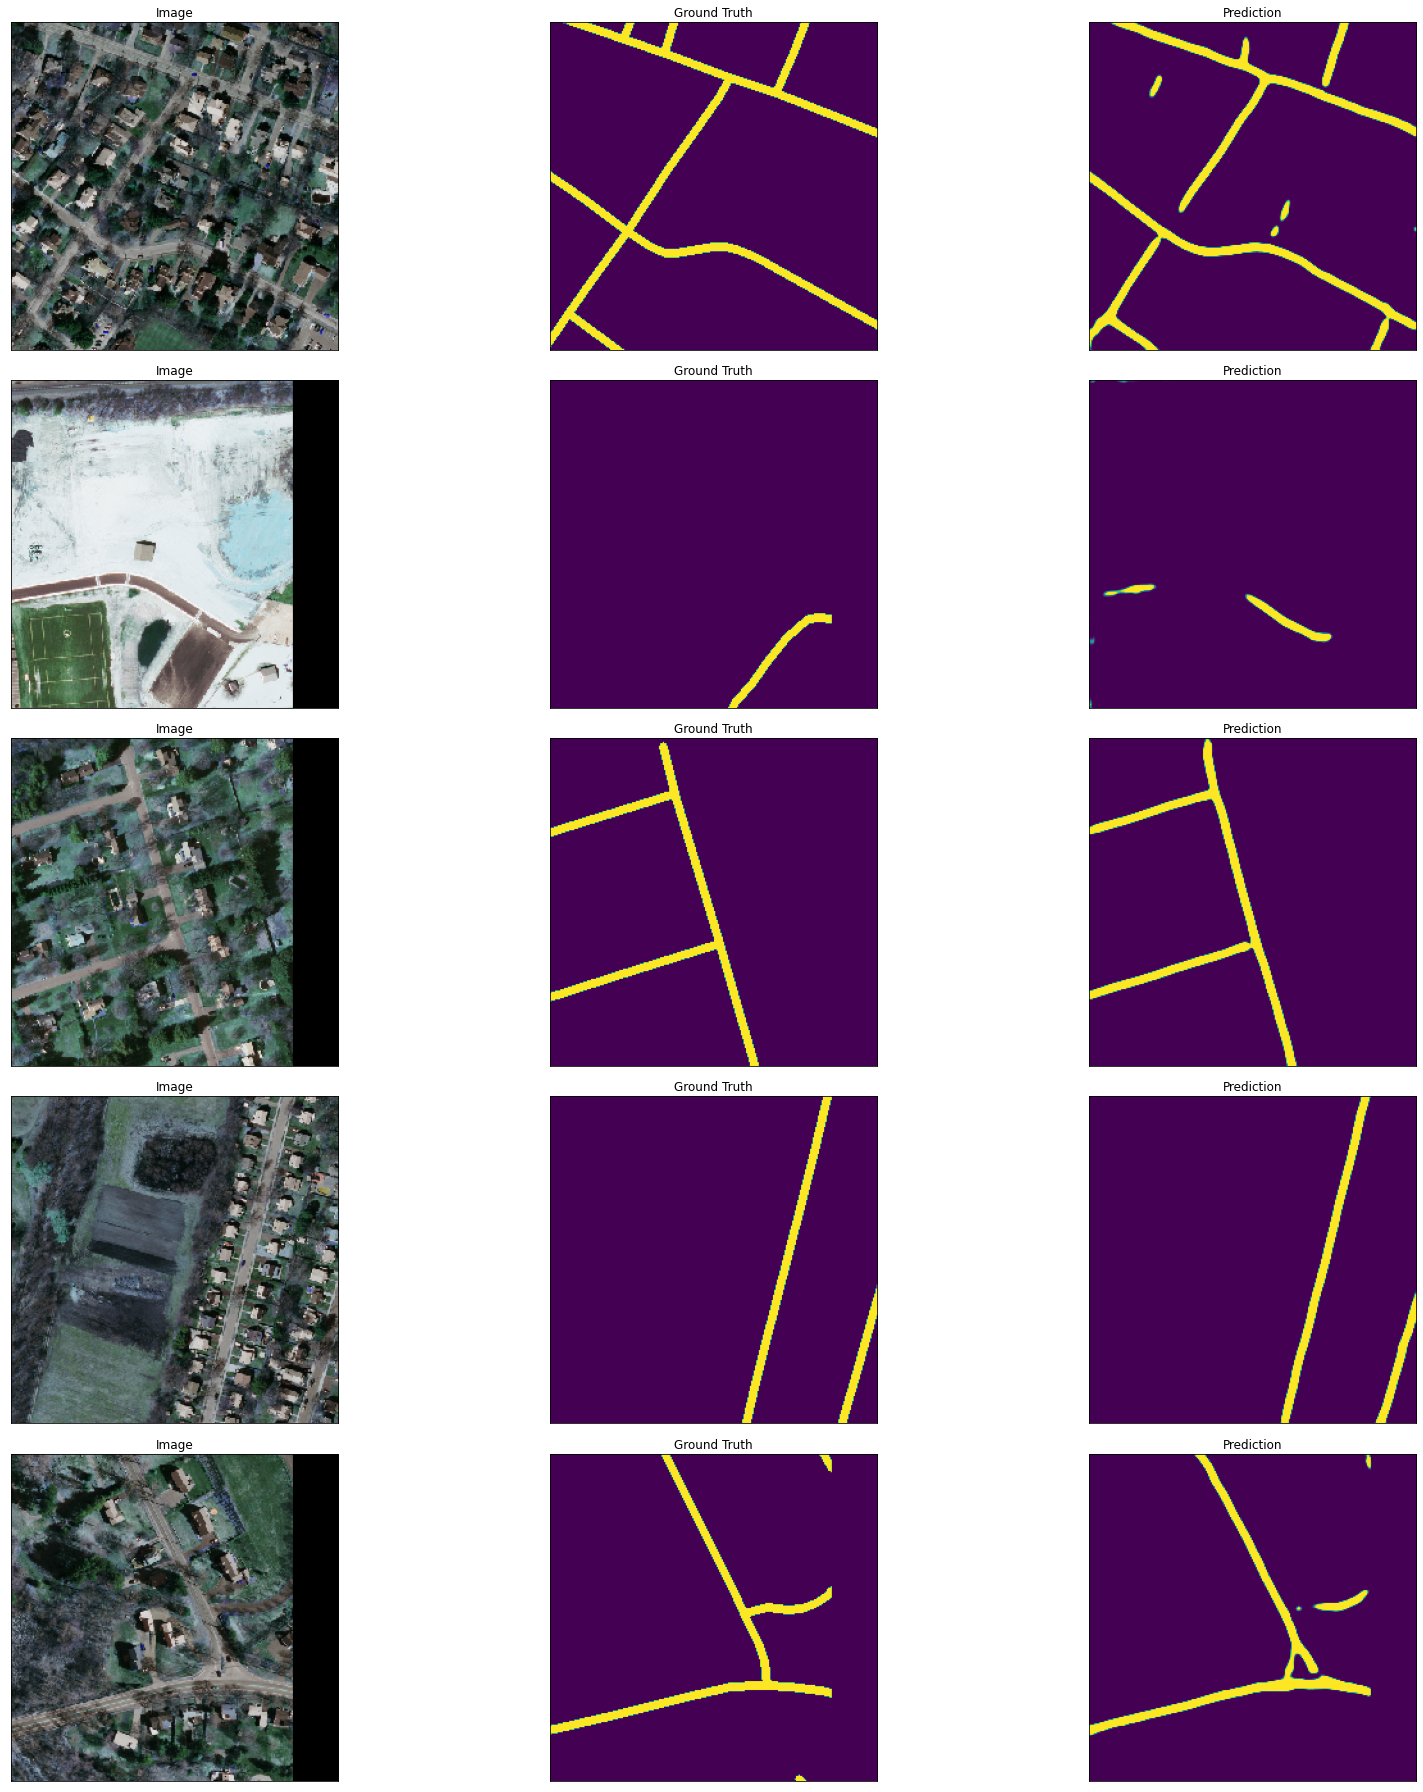

In [43]:
cnt = 0
plt.figure(figsize = (25,25))
for ind in range(3,8):
  cnt += 1
  plt.subplot(5,3,cnt)
  plt.imshow(X_test[ind])
  plt.xticks([])
  plt.yticks([])
  plt.title('Image')

  cnt += 1
  plt.subplot(5,3,cnt)
  plt.imshow(y_test[ind].reshape(256,256))
  plt.xticks([])
  plt.yticks([])
  plt.title('Ground Truth')

  cnt += 1  
  plt.subplot(5,3,cnt)
  plt.imshow(predictions[ind].reshape(256,256))
  plt.xticks([])
  plt.yticks([])
  plt.title('Prediction')
plt.tight_layout()

### Summary

- In this report, we built a UNet Deep Learning model for segmenting aerial images of Masachusetts to identify roads from the images. 

- Due to RAM constraints, the model was built with a small fraction (2000 images) of the total training data (~21000 images) however the predictions of the model are still quite good on the test images. 

- Further work on the model front can be along the following lines:
  - Training the model on the entire training dataset
  - Transforming input images (rotation, scaling, translation) to add more diversity to the training dataset 
  - Configuring various parameters of the Unet model